In [28]:
import brian2 as br
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy
import scipy as sp
from scipy import optimize as op
import seaborn as sns

import dh_parameters as dp
import dh_model as dh

%matplotlib notebook
reload(dp);
reload(dh);
cmap = sns.color_palette('hls',4)

In [213]:
nts = ['pr_noci','e_nts','i_gal']
ats = ['pep2','AB_ltmr']
Ns = dp.get_Ns()
intrinsics_df = dp.intrinsics_table_w_units()
ng_output_dfs = dp.interneuronal_connectivity_tables()
ag_output_dfs = dp.afferent_connectivity_tables()
ndf = {}
adf ={}

for param,df in ng_output_dfs.items():
    ndf[param] = ng_output_dfs[param].loc[['pr_noci','e_nts','i_gal'],['pr_noci','e_nts','i_gal']]

for param,df in ag_output_dfs.items():
    adf[param] = ag_output_dfs[param].loc[['pep2'],['pr_noci','e_nts','i_gal']]    
    
for param,df in ndf.items():
    ndf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    ndf[param].index = ['pr_noci', 'e_nts', 'i_WDR']
    
for param,df in adf.items():
    adf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    
ndf['p'].loc['i_WDR'] = [1,1,1]
ndf['w_mu'].loc['i_WDR'] = [1.e-9,1.5e-9,0.5e-9]
ndf['w_sigma'].loc['i_WDR'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['i_WDR']=['i','i','i']

ndf['p'].loc['e_nts'] = [.2,0.5,0.35]
ndf['w_mu'].loc['e_nts'] = [0.25e-9,0.25e-9,0.25e-9]
ndf['w_sigma'].loc['e_nts'] = [1e-10,0.25e-9,0.5e-9]
ndf['conductance_name'].loc['e_nts']=['e','e','e']

adf['p'].loc['pep2'] = [.2,0.2,.2]
adf['w_mu'].loc['pep2'] = [1.5e-9,1e-9,1e-9]
adf['w_sigma'].loc['pep2'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['pep2']=['e','e','e']

adf['p'].loc['AB_ltmr'] = [0.,0.5,0.5]
adf['w_mu'].loc['AB_ltmr'] = [1e-9,1e-9,0.25e-9]
adf['w_sigma'].loc['AB_ltmr'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['AB_ltmr']=['e','e','e']


nts = ['pr_noci', 'e_nts', 'i_WDR']
Ns['pr_noci'] = 20
Ns['e_nts'] = 40
Ns['i_WDR'] = 20
Ns['pep2'] = 200
Ns['AB_ltmr'] = 200

intrinsics_df.loc['i_WDR'] = intrinsics_df.loc['i_gal']

for nt in nts:
    intrinsics_df.loc[nt,'tau_r'] = 0.2 
    intrinsics_df.loc[nt,'V_r'] = -55 
    intrinsics_df.loc[nt,'tau_u'] = 10
    intrinsics_df.loc[nt,'alpha'] = 1
    intrinsics_df.loc[nt,'b'] = 10
    
intrinsics_df.loc['i_WDR','b'] = 0
intrinsics_df.loc['i_WDR','alpha'] = 0.1
intrinsics_df.loc['i_WDR','g_l_mu'] = 4

In [214]:
reload(dh)

ds = dh.sim()
ds['dt'] = sim_dt = 0.1*br.ms
ds['nts'] = nts
ds['ats'] = ats
ds['adf'] = adf
ds['ndf'] = ndf
ds['intrinsics_df'] = intrinsics_df.loc[nts + ['units'],:]
ds['Ns'] = Ns

ds.initialize_sim_objects()
wdf,wmat = ds.get_weight_matrix()

In [215]:
#output = tensor: rates x psth x num_trials

block_length = 2
conditions = 1
num_repeats = 1
duration = 5000 * br.ms
num_trials = block_length * conditions * num_repeats
print('num_trials = '+ str(num_trials))
trial_durations = [duration] * num_trials
ds.initialize_inputs(trial_durations)

#let's make this simpler

psth_kernel,_ = dh.gaussian_psth(duration, ds['dt'], mu = 2500 * br.ms, sigma = 2500 * br.ms)

# off_time_frac = 0.2
# psth_kernel,_ = dh.uniform_psth(duration*(1-off_time_frac), ds['dt'])

# psth_kernel = np.concatenate([np.zeros(int(duration*off_time_frac/ds['dt'])),psth_kernel])

rates_of_active_pep2 = np.concatenate([np.linspace(1,2,block_length)]  * num_repeats)
rates_of_active_AB_ltmr = np.concatenate([np.linspace(2.5,5,block_length)]  * num_repeats)


frac_active_pep2= np.ones(num_trials)
frac_active_AB_ltmr = np.ones(num_trials)

heat = ([True]*block_length)  * num_repeats


mech = ([True] * block_length)  * num_repeats

at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices


psth_kernel,_ = dh.gaussian_psth(duration, ds['dt'], mu = 2000 * br.ms, sigma = 150 * br.ms)
at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr,
                   'rates_of_active_pep2':rates_of_active_pep2,
                   'rates_of_active_AB_ltmr':rates_of_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech

ds.initialize_target_outputs()
ds.finalize_inputs()

# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     ds['inputs'][trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

num_trials = 2


In [216]:
ds['network'].restore()

In [217]:

ds.run_sim()
observed_spikes = ds.get_trialwise_spikes()
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    df[nt+'_mean_rate'] = this_rates

spikes_df = dh.spikes_to_df(ds)

In [218]:
%matplotlib notebook

<IPython.core.display.Javascript object>


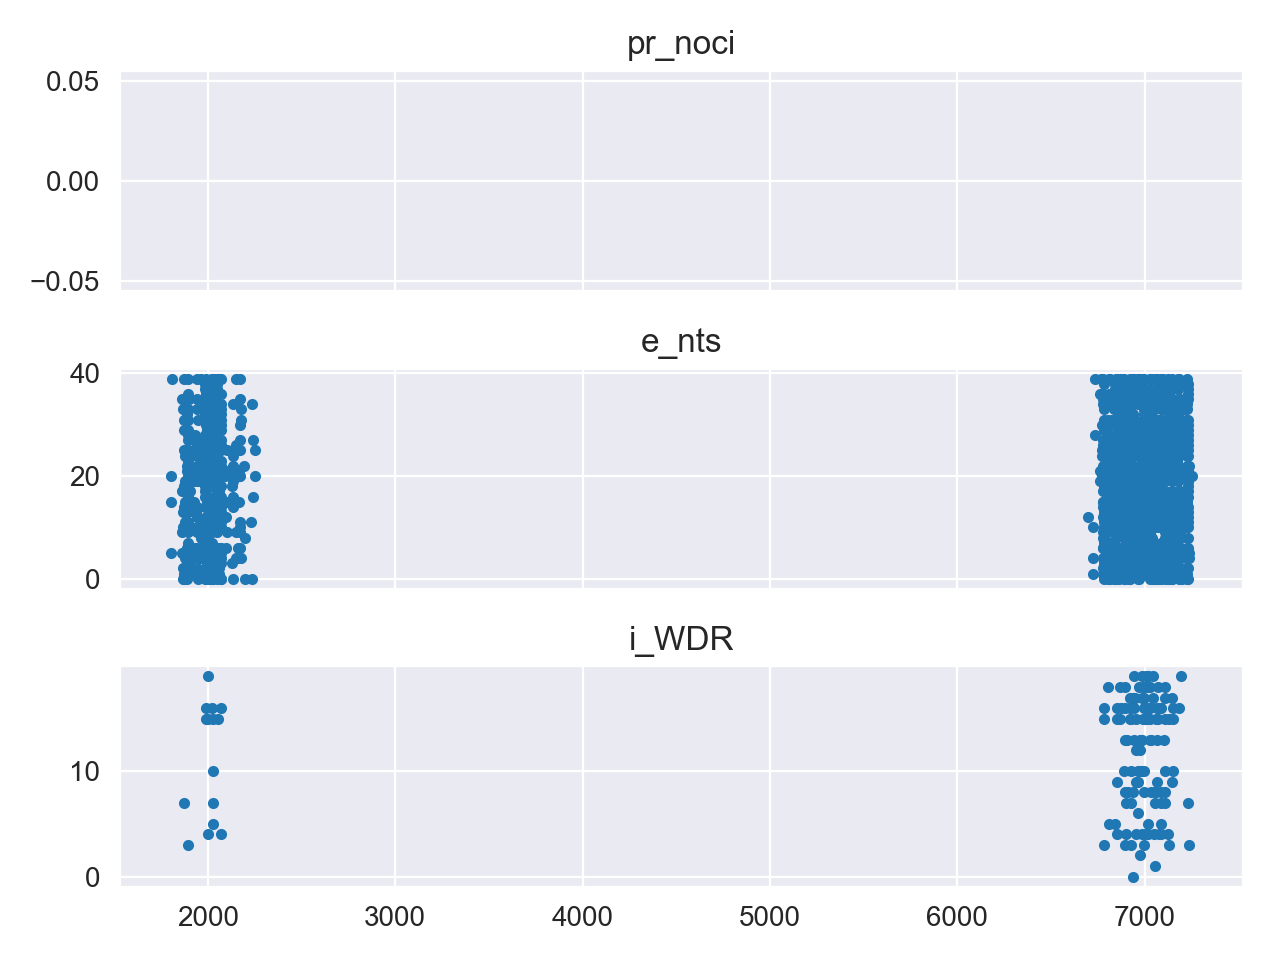

(<Figure size 640x480 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e2d8c88>,
       dtype=object))

In [219]:
ds.plot_ng_rasters()

In [220]:
dh.make_all_sim_spikes_pretty(ds)

In [221]:
sns.set_style('darkgrid')

<IPython.core.display.Javascript object>


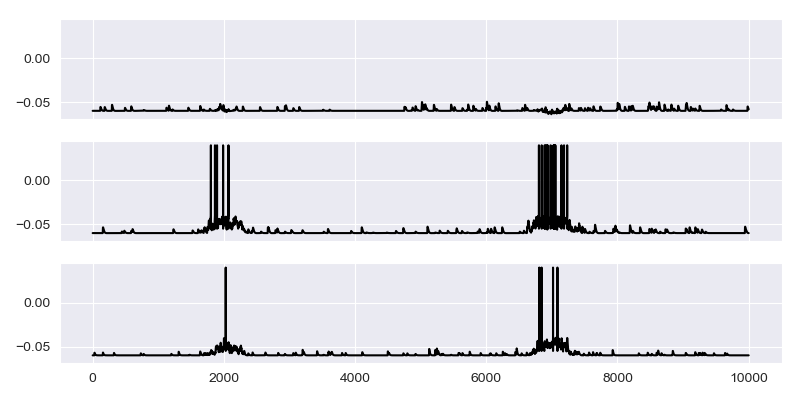

5


In [224]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (8,4), sharex = True,sharey = True)
ax = ax.flatten()
y_bias = 0
# state_mon =ds['state_mons']['pr_noci']
z = np.random.choice(20)
for j, nt in enumerate(ds['state_mons']):
    state_mon =ds['state_mons'][nt]
#     ax[j].plot(state_mon.t/br.ms, state_mon.v[0,:], color = cmap[j]);
    ax[j].plot(state_mon.t/br.ms, state_mon.v[z,:], color = 'k');
#     y_bias += ngs[ct].N
#     ax[j].set_xlim((0,200))
y_bias+=1
plt.tight_layout()
print(z)
# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

<IPython.core.display.Javascript object>


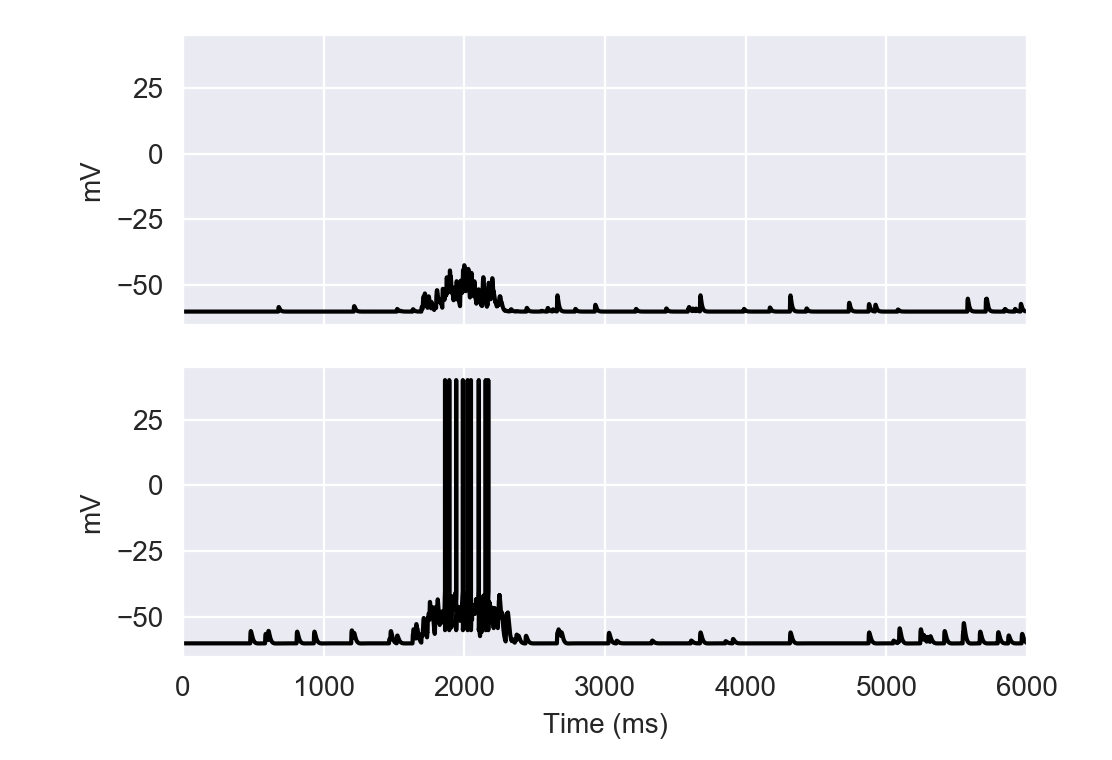

In [223]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(2,1,figsize = (4,4), sharex = True,sharey = True)
ax = ax.flatten()
y_bias = 0
# state_mon =ds['state_mons']['pr_noci']
state_mon =ds['state_mons']['e_nts']
ax[1].plot(state_mon.t/br.ms, state_mon.v[9,:]/br.mV, color = 'k');
state_mon =ds['state_mons']['i_WDR']
ax[0].plot(state_mon.t/br.ms, state_mon.v[9,:]/br.mV, color = 'k');
#     y_bias += ngs[ct].N
ax[0].set_xlim((0,6000))
ax[0].set_ylabel('mV')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('mV')
plt.tight_layout()

In [107]:
f.savefig('/Users/nakaa1/Documents/Presentations/20190503_postdoc_meeting/vm_example.png',dpi=300)